**Tâche 2 : Exploration & Analyse**

Objectifs

Cette tâche vise à tester la capacité des candidats à transformer un dataset consolidé en un support d’analyse riche et pertinent, en combinant rigueur statistique, créativité analytique et préparation pour un usage décisionnel (Power BI).

Les candidats devront démontrer leur maîtrise de l’analyse exploratoire, la détection d’anomalies, la création d’indicateurs dérivés, et la structuration de données prêtes pour un tableau de bord interactif.

Missions

- Explorer les données
- Réaliser une analyse descriptive approfondie pour mettre en évidence:
les tendances historiques (ex. évolution démographique, évolution du PIB, scolarisation),
les dynamiques spatiales (variations entre régions, départements, communes).
- Identifier et documenter des corrélations croisées
- Détecter les anomalies et incohérences :
- Créer de nouvelles variables et indicateurs
- Construire des indicateurs avancés tels que :
taux : croissance annuelle de la population
ratios : population jeune.
indices composites : indicateur de développement régional.
Produire des agrégations temporelles et spatiales :
agrégations par département ou région, normalisation par habitant.

Livrables :

Dataset enrichi avec variables calculées et mis à disposition sur un GIT ou Drive
Notebook ou rapport intermédiaire d’analyse.
Liste documentée des anomalies et choix méthodologiques.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
benin_df = pd.read_parquet("./Donnees_ben_pop.parquet")
benin_df.head()

,Année,Population 1er Juin,Population Masculine 1er Juin,Population Féminine 1er Juin,Naissances,Décès,Espérance de vie à la naissance,Solde migratoire,Taux de migration net,PIB_prix_constant,Population 0-14,Population 15-59,Population 60+
0,1962.0,2604.659,1236.778,1367.880,122.713,71.049,39.643,-4.844,-1.860,9.910000e+11,1039.7865,1337.6690,227.2030
1,1963.0,2652.908,1261.327,1391.581,125.726,71.212,40.081,-4.847,-1.827,1.110000e+12,1070.0615,1355.3845,227.4620
2,1964.0,2704.003,1287.274,1416.729,128.765,71.412,40.502,-4.839,-1.790,1.190000e+12,1102.3680,1373.6455,227.9895
3,1965.0,2757.936,1314.605,1443.331,131.635,71.482,40.971,-4.793,-1.738,1.250000e+12,1136.7295,1392.4375,228.7690
4,1966.0,2814.317,1343.249,1471.068,134.106,71.937,41.274,-4.764,-1.693,1.300000e+12,1172.1035,1412.5000,229.7135


In [13]:
benin_df.columns

Index(['Année', 'Population 1er Juin', 'Population Masculine 1er Juin',
       'Population Féminine 1er Juin', 'Naissances', 'Décès',
       'Espérance de vie à la naissance', 'Solde migratoire',
       'Taux de migration net', 'PIB_prix_constant', 'Population 0-14',
       'Population 15-59', 'Population 60+'],
      dtype='object')

Descriptives statistiques

In [10]:
def nuage_de_points(x:str, y: str, donnees: pd.DataFrame):
    if x in donnees.columns and y in donnees.columns:
        plt.scatter(x=x, y=y, data=donnees)
        plt.ylabel(y)
        plt.xlabel(x)
        plt.title(f"Evolution de ({y}) selon ({x})")
        plt.show()
    else:
        print(f"Une des ou toutes les colonnes ({x} et {y}) n'existent pas dans la base.")

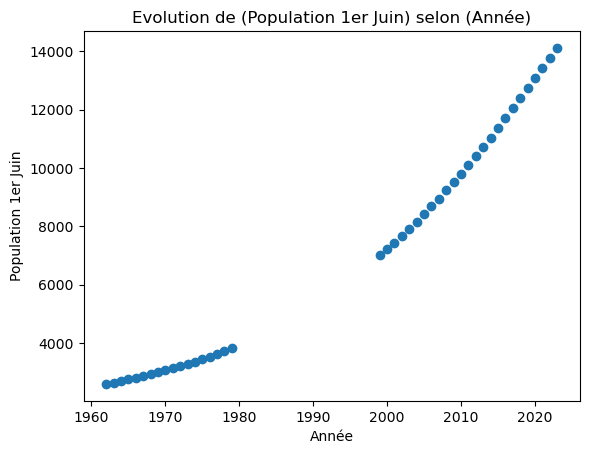

In [ ]:
nuage_de_points(x = "Année",y="Population 1er Juin", donnees=benin_df)

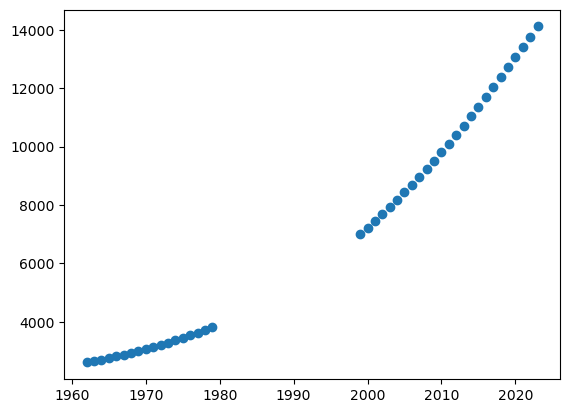

In [ ]:
plt.scatter(x = "Année", y="Population 1er Juin", data=benin_df)
plt.scatter()
plt.show()